In [1]:
import os
import platform
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm
from utils import general_process
import numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from flaml import AutoML
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_context('notebook')
sns.set_theme(style="ticks", palette="bright")
plt.style.use(['grid'])

# 设置字体
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# 加载数据
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

# 计算磁通密度的峰值
df['flux_density_max'] = df['flux_density'].apply(lambda r: np.max(r))
df['type_material'] = df['type_material'].astype('category')
df['type_waveform'] = df['type_waveform'].astype('category')

# 准备模型的输入和输出
X_train = df[['type_material', 'temp', 'freq', 'type_waveform', 'flux_density_max']]
y_train = df['core_loss']

In [2]:
type(X_train.head(1).iloc[0, 0])

str

## 模型训练 & 自动调参

In [3]:
# Encode categorical variables
label_encoders = {}
for col in ['type_material', 'type_waveform']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le

# Define AutoML settings
automl_settings = {
    "time_budget": 30,  # in seconds
    "estimator_list": ['lgbm'],
    "metric": 'mae',
    "task": 'regression',
    "log_file_name": "automl.log",
    "early_stop": True,
    "eval_method": "holdout",
    "seed": 20240924,
    "verbose": 3,
    "log_type": "better",
    "ensemble": True
}

# Initialize and train the model
automl = AutoML()
automl.fit(X_train, y_train, **automl_settings)

[flaml.automl.logger: 09-24 20:39:37] {1693} INFO - task = regression
[flaml.automl.logger: 09-24 20:39:37] {1700} INFO - Data split method: uniform
[flaml.automl.logger: 09-24 20:39:37] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-24 20:39:37] {1801} INFO - Minimizing error metric: mae
[flaml.automl.logger: 09-24 20:39:37] {1911} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 09-24 20:39:37] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-24 20:39:37] {2347} INFO - Estimated sufficient time budget=334s. Estimated necessary time budget=0s.
[flaml.automl.logger: 09-24 20:39:37] {2394} INFO -  at 0.1s,	estimator lgbm's best error=186024.5838,	best estimator lgbm's best error=186024.5838
[flaml.automl.logger: 09-24 20:39:37] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-24 20:39:37] {2394} INFO -  at 0.1s,	estimator lgbm's best error=186024.5838,	best estimator lgbm's best error=186024.5838


In [5]:
# Print the best hyperparameters and MAE
print('Best hyperparameter config:', automl.best_config)
print('Best MAE:', automl.best_loss)
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparameter config: {'n_estimators': 107, 'num_leaves': 526, 'min_child_samples': 7, 'learning_rate': 0.1765334724130322, 'log_max_bin': 10, 'colsample_bytree': 0.9619523269222047, 'reg_alpha': 0.12439838310815182, 'reg_lambda': 0.6198861998338202}
Best MAE: 13757.202028384954
Training duration of best run: 6.735 s
LGBMRegressor(colsample_bytree=0.9619523269222047,
              learning_rate=0.1765334724130322, max_bin=1023,
              min_child_samples=7, n_estimators=1, n_jobs=-1, num_leaves=526,
              reg_alpha=0.12439838310815182, reg_lambda=0.6198861998338202,
              verbose=-1)


In [6]:
demo = np.array([1, 25, 50020, '正弦波', 0.031419])
demo = demo.reshape(1, -1)
automl.predict(demo)

array([2264.23540883])

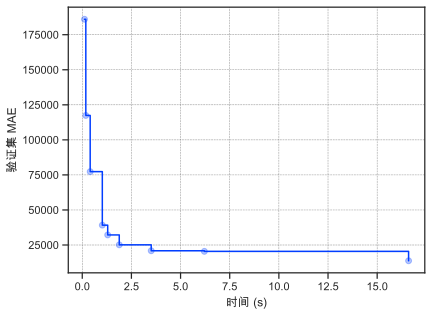

In [7]:
from flaml.automl.data import get_output_from_log
import numpy as np

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(
    filename=automl_settings['log_file_name'], time_budget=automl_settings['time_budget'])
plt.xlabel('时间 (s)')
plt.ylabel('验证集 MAE')
plt.step(time_history, np.array(best_valid_loss_history), where='post')
plt.scatter(time_history, np.array(best_valid_loss_history), alpha=0.3)
plt.savefig('figures/p4-learning_curve.pdf', bbox_inches='tight')

## 特征重要性

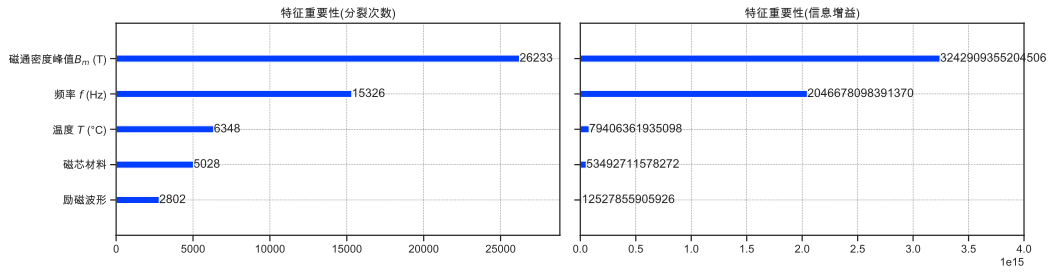

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
mapping = {
    'type_material': '磁芯材料',
    'temp': '温度 $T$ (°C)',
    'freq': '频率 $f$ (Hz)',
    'type_waveform': '励磁波形',
    'flux_density_max': '磁通密度峰值$B_m$ (T)'
}

# plt.barh([mapping.get(feature, feature) for feature in automl.feature_names_in_], automl.feature_importances_)

# plot feature importance for split
lgb.plot_importance(automl.model.estimator, importance_type="split", title="LightGBM Feature Importance (Gain)", ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].set_title('特征重要性(分裂次数)')
axes[0].set_yticklabels([mapping.get(label.get_text(), label.get_text()) for label in axes[0].get_yticklabels()])

# plot feature importance for gain
lgb.plot_importance(automl.model.estimator, importance_type="gain", title="LightGBM Feature Importance (Gain)", ax=axes[1], precision=0)
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_title('特征重要性(信息增益)')
axes[1].set_yticklabels([])
# axes[1].set_yticklabels([mapping.get(label.get_text(), label.get_text()) for label in axes[1].get_yticklabels()])
axes[1].set_xlim([0, 4e15])
plt.tight_layout()
plt.savefig('figures/p4-plot_importance.pdf', bbox_inches='tight')

In [9]:
# use the model to predict
y_pred = automl.predict(X_train)
# plot the predicted and actual values
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.3)
plt.xlabel('磁芯损耗(真实值)')
plt.ylabel('磁芯损耗(预测值)')
plt.savefig('figures/p4-true_vs_pred.pdf', bbox_inches='tight')

## 保存模型

In [10]:
with open('model_and_encoders.pkl', 'wb') as f:
    pickle.dump({
        'model': automl,
        'label_encoders': label_encoders
    }, f)

In [23]:
# load the model
with open('model_and_encoders.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

model = loaded_data['model']
label_encoders = loaded_data['label_encoders']

## 测试结果

In [12]:
test_df = pd.read_excel('dataset/附件三（测试集）.xlsx')
column_mapping = {
    '温度，oC': 'temp',
    '频率，Hz': 'freq',
    '磁芯损耗，w/m3': 'core_loss',
    '0（磁通密度B，T）': 0,
    '励磁波形': 'type_waveform',
    '磁芯材料': 'type_material',
}
test_df.rename(columns=column_mapping, inplace=True)
test_df['flux_density'] = test_df.iloc[:, 5:].values.tolist()
test_df.drop(columns=[i for i in range(1024)], inplace=True)
test_df['flux_density_max'] = test_df['flux_density'].apply(lambda r: np.max(r))
test_df['type_material'] = test_df['type_material'].apply(lambda r: r.replace('材料', ''))
test_df.head(1)

,序号,temp,freq,type_material,type_waveform,flux_density,flux_density_max
0,1,25,56320,1,正弦波,"[0.002215526, 0.002596693, 0.002976955, 0.0033...",0.062438


In [13]:
X_test = test_df[['type_material', 'temp', 'freq', 'type_waveform', 'flux_density_max']]
for col in ['type_material', 'type_waveform']:
    le = label_encoders[col]
    X_test[col] = le.transform(X_test[col])
y_pred = model.predict(X_test)
y_pred.shape

(400,)

In [14]:
# write to csv
test_df['core_loss'] = y_pred
test_df.drop(columns=['flux_density'], inplace=True)
test_df.to_csv('p4.csv', index=False)

In [15]:
test_df['core_loss_steinmetz'] = 1222.0 * test_df['freq'] ** 1.467 * test_df['flux_density_max'] ** 2.451 * \
    (0.001405 - 1.744 * 1e-5 * test_df['temp'] + 9.797 * 1e-8 * test_df['temp'] ** 2)
test_df.head(1)

,序号,temp,freq,type_material,type_waveform,flux_density_max,core_loss,core_loss_steinmetz
0,1,25,56320,1,正弦波,0.062438,17459.169787,13087.947426


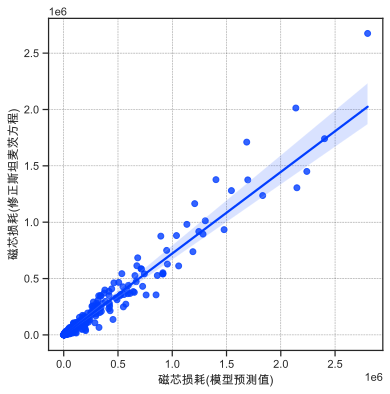

In [16]:
# plot the predicted and actual values
plt.figure(figsize=(6, 6))
sns.regplot(data=test_df, x='core_loss', y='core_loss_steinmetz', robust=True)
# plt.scatter(test_df['core_loss'], test_df['core_loss_steinmetz'], alpha=0.3)
plt.xlabel('磁芯损耗(模型预测值)')
plt.ylabel('磁芯损耗(修正斯坦麦茨方程)')
plt.savefig('figures/p4-test-steinmetz_vs_pred.pdf', bbox_inches='tight')

## 模型对比

Steinmetz & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta}$ \\
Quadratic & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta} \cdot \left(c_{1} \cdot T^{2} + c_{2} \cdot T + d\right)$ \\
Steinmetz & $P = 2.427 \cdot f^{1.365} \cdot B_{m}^{2.127}$ \\
Quadratic & $P = 3465.0 \cdot f^{1.348} \cdot B_{m}^{2.118} \cdot \left(0.001303 - 1.295 \cdot 10^{-5} \cdot T + 7.57 \cdot 10^{-8} \cdot T^{2}\right)$ \\


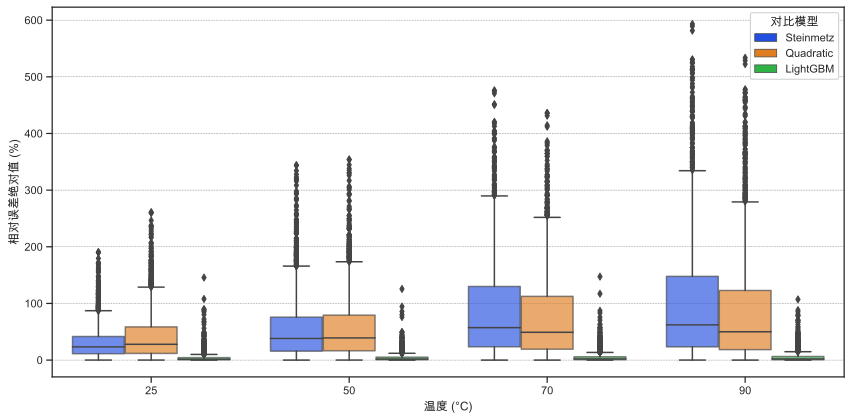

In [22]:
from sklearn.metrics import r2_score
# use scipy to simplify function definition process and support Latex output
import sympy as sp
from sympy import symbols, exp, log, latex
from sympy.utilities.lambdify import lambdify
from scipy.optimize import curve_fit

freq, flux_density_max, temp = symbols('f B_m T', commutative=False)
k, alpha, beta, c, d, k1, k2, c1, c2 = symbols('k alpha beta c d k1 k2 c1 c2')


def def2numerical(function_definitions):
    numerical_functions = {}
    for name, expr, params in function_definitions:
        # create a lambda function for numerical computation
        func_num = lambdify(
            (freq, flux_density_max, temp, *params),
            expr,
            modules=['numpy']
        )
        # define a wrapper function for curve_fit

        def func_wrapper(xdata, *args, func_num=func_num):
            freq_data, flux_density_max_data, temp_data = xdata
            return func_num(freq_data, flux_density_max_data, temp_data, *args)
        numerical_functions[name] = (func_wrapper, params)
    return numerical_functions


function_definitions = [
    ('Steinmetz', k * freq**alpha * flux_density_max**beta + 0 * temp, [k, alpha, beta]),
    ('Quadratic', k * freq**alpha * flux_density_max**beta * (c1 * temp**2 + c2 * temp + d), [k, alpha, beta, c1, c2, d]),
    # ('Sigmoid', k * freq**alpha * flux_density_max**beta / (1 + exp(-(c * temp + d))), [k, alpha, beta, c, d]),
]

numerical_functions = def2numerical(function_definitions)
for name, (expr, params) in zip(numerical_functions.keys(), [item[1:] for item in function_definitions]):
    # print the function with parameters if fitting failed
    latex_expr = latex(expr, mul_symbol=' \cdot ')
    print(f"{name} & $P = {latex_expr}$ \\\\")

xdata = df[['freq', 'flux_density_max', 'temp']].values.T
ydata = df['core_loss'].values

popt_values = {}
eval_metrics = ['R2', 'MSE', 'RMSE', 'MAE']
scores = {metric: {} for metric in eval_metrics}

for name, (func, params) in numerical_functions.items():
    if scores['R2'].get(name) is None:
        name_model = 'LightGBM'
        df[f'core_loss_{name_model.lower()}'] = automl.predict(X_train)
        df[f'relative_error_{name_model.lower()}'] = (np.abs(df['core_loss'] - df[f'core_loss_{name_model.lower()}']) / df['core_loss']) * 100
        scores['R2'][name_model] = r2_score(ydata, df[f'core_loss_{name_model.lower()}'])
        scores['MSE'][name_model] = np.mean((ydata - df[f'core_loss_{name_model.lower()}'])**2)
        scores['RMSE'][name_model] = np.sqrt(scores['MSE'][name_model])
        scores['MAE'][name_model] = np.mean(np.abs(ydata - df[f'core_loss_{name_model.lower()}']))
    xxdata = xdata
    p0 = [1.0, 2, 2.5] + [0.0] * (len(params) - 3)
    popt, _ = curve_fit(func, xxdata, ydata, p0=p0, maxfev=10000)
    popt_values[name] = popt
    df[f'core_loss_{name.lower()}'] = func(xxdata, *popt)
    df[f'relative_error_{name.lower()}'] = (np.abs(df['core_loss'] - df[f'core_loss_{name.lower()}']) / df['core_loss']) * 100

    # calculate evaluation metrics
    scores['R2'][name] = r2_score(ydata, df[f'core_loss_{name.lower()}'])
    scores['MSE'][name] = np.mean((ydata - df[f'core_loss_{name.lower()}'])**2)
    scores['RMSE'][name] = np.sqrt(scores['MSE'][name])
    scores['MAE'][name] = np.mean(np.abs(ydata - df[f'core_loss_{name.lower()}']))

for name, (expr, params) in zip(numerical_functions.keys(), [item[1:] for item in function_definitions]):
    popt = popt_values.get(name)
    if popt is not None:
        # create a dictionary of parameter substitutions
        param_subs = dict(zip(params, popt))
        # substitute numerical values into the symbolic expression
        expr_subs = expr.subs(param_subs)
        # round numerical values to four decimal places
        expr_subs = expr_subs.evalf(4)
        # generate LaTeX expression
        latex_expr = latex(expr_subs, mul_symbol=' \cdot ')
        print(f"{name} & $P = {latex_expr}$ \\\\")

# create a new dataframe for plotting
plot_df = pd.DataFrame()
for name, (func, _) in list(numerical_functions.items()) + [('LightGBM', (None, []))]:
    temp_df = df[['temp', f'relative_error_{name.lower()}']].copy()
    temp_df['Function'] = name
    temp_df.rename(columns={f'relative_error_{name.lower()}': 'Relative Error'}, inplace=True)
    temp_df['R2'] = scores['R2'][name]
    temp_df['MSE'] = scores['MSE'][name]
    temp_df['RMSE'] = scores['RMSE'][name]
    temp_df['MAE'] = scores['MAE'][name]
    plot_df = pd.concat([plot_df, temp_df], ignore_index=True)

# create a dataframe for LaTeX table
latex_df = pd.DataFrame(scores)

# find the minimum error values and mark them with bold and asterisk
for metric in eval_metrics:
    value = latex_df[metric].min()
    if metric == 'R2':
        value = latex_df[metric].max()
    latex_df[metric] = latex_df[metric].apply(lambda x: f"\\textbf{{{x:.4f}}}*" if x == value else f"{x:.4f}")

# plot boxplot with hue as different functions
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='temp', y='Relative Error', hue='Function', boxprops=dict(alpha=.65))
plt.ylabel("相对误差绝对值 (%)")
plt.xlabel("温度 (°C)")
plt.legend(title='对比模型')
plt.tight_layout()
plt.savefig('figures/p4-error-contrast.pdf', bbox_inches='tight')

In [19]:
latex_table = latex_df.to_latex(index=True, caption='Evaluation Metrics for Different Functions')
print(latex_table)

\begin{table}
\caption{Evaluation Metrics for Different Functions}
\begin{tabular}{lllll}
\toprule
 & R2 & MSE & RMSE & MAE \\
\midrule
LightGBM & \textbf{0.9995}* & \textbf{72747222.8701}* & \textbf{8529.1983}* & \textbf{2594.8950}* \\
Steinmetz & 0.9359 & 9073983602.2359 & 95257.4596 & 47756.1462 \\
Quadratic & 0.9561 & 6214319763.7441 & 78830.9569 & 41800.2294 \\
\bottomrule
\end{tabular}
\end{table}



## 泛化能力

In [24]:
df['flux_density_max'].describe()

count    12400.000000
mean         0.077533
std          0.067873
min          0.009638
25%          0.027441
50%          0.049793
75%          0.100297
max          0.313284
Name: flux_density_max, dtype: float64

In [25]:
df.shape

(12400, 13)

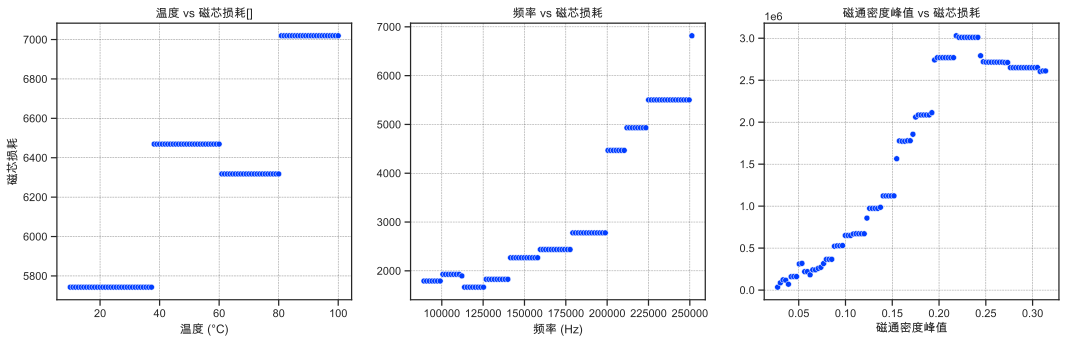

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


def create_demo_df(n, freq, flux_density_max, temp, type_waveform, type_material):
    return pd.DataFrame({
        'freq': freq,
        'flux_density_max': flux_density_max,
        'temp': temp,
        'type_waveform': type_waveform,
        'type_material': type_material
    })


def encode_columns(df, columns):
    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df


def plot_prediction(df, x_col, ax):
    y_pred = model.predict(df)
    sns.scatterplot(x=df[x_col], y=y_pred, ax=ax)


n = 100
df_demo = create_demo_df(
    n,
    [396840.8] * n,
    [0.012729] * n,
    np.linspace(10, 100, n),
    ['正弦波'] * n,
    ['1'] * n
)
df_demo = encode_columns(df_demo, ['type_material', 'type_waveform'])
plot_prediction(df_demo, 'temp', axes[0])

df_demo = create_demo_df(
    n,
    np.linspace(89210, 251240, n),
    [0.012429] * n,
    [90] * n,
    ['正弦波'] * n,
    ['4'] * n
)
df_demo = encode_columns(df_demo, ['type_material', 'type_waveform'])
plot_prediction(df_demo, 'freq', axes[1])

df_demo = create_demo_df(
    n,
    [396820.8] * n,
    np.linspace(0.027448, 0.31384, n),
    [90] * n,
    ['正弦波'] * n,
    ['1'] * n
)
df_demo = encode_columns(df_demo, ['type_material', 'type_waveform'])
plot_prediction(df_demo, 'flux_density_max', axes[2])

axes[0].set_title('温度 vs 磁芯损耗[]')
axes[0].set_xlabel('温度 (°C)')
axes[1].set_title('频率 vs 磁芯损耗')
axes[1].set_xlabel('频率 (Hz)')
axes[2].set_title('磁通密度峰值 vs 磁芯损耗')
axes[2].set_xlabel('磁通密度峰值')
axes[0].set_ylabel('磁芯损耗')
plt.savefig('figures/p4-generalizable-tree.pdf', bbox_inches='tight')

# 后记：为深度学习准备数据

In [45]:
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

df['flux_density_max'] = df['flux_density'].apply(lambda r: np.max(r))
df['type_material'] = df['type_material'].apply(lambda r: '材料' + r)
df['type_material'] = df['type_material'].astype('category')
df['type_waveform'] = df['type_waveform'].astype('category')
df = pd.get_dummies(df, columns=['type_material', 'type_waveform'], prefix='', prefix_sep='')
df = df[['freq', 'flux_density_max', 'temp', '材料1', '材料2', '材料3', '材料4', '三角波', '梯形波', '正弦波', 'core_loss']]

with open('train_data_dl.pkl', 'wb') as fout:
    pickle.dump(df, fout)

df.head()

,freq,flux_density_max,temp,材料1,材料2,材料3,材料4,三角波,梯形波,正弦波,core_loss
0,50030,0.028849,25,True,False,False,False,False,False,True,1997.955250
1,50020,0.031419,25,True,False,False,False,False,False,True,2427.749830
2,50020,0.035535,25,True,False,False,False,False,False,True,3332.725760
3,50020,0.040015,25,True,False,False,False,False,False,True,4502.908007
4,50030,0.045028,25,True,False,False,False,False,False,True,6063.023248


In [46]:
test_df = pd.read_excel('dataset/附件三（测试集）.xlsx')
column_mapping = {
    '温度，oC': 'temp',
    '频率，Hz': 'freq',
    '磁芯损耗，w/m3': 'core_loss',
    '0（磁通密度B，T）': 0,
    '励磁波形': 'type_waveform',
    '磁芯材料': 'type_material',
}
test_df.rename(columns=column_mapping, inplace=True)
test_df['flux_density'] = test_df.iloc[:, 5:].values.tolist()
test_df.drop(columns=[i for i in range(1024)], inplace=True)

test_df['flux_density_max'] = test_df['flux_density'].apply(lambda r: np.max(r))
test_df['type_material'] = test_df['type_material'].astype('category')
test_df['type_waveform'] = test_df['type_waveform'].astype('category')
test_df = pd.get_dummies(test_df, columns=['type_material', 'type_waveform'], prefix='', prefix_sep='')
test_df = test_df[['freq', 'flux_density_max', 'temp', '材料1', '材料2', '材料3', '材料4', '三角波', '梯形波', '正弦波']]

with open('test_data_dl.pkl', 'wb') as fout:
    pickle.dump(test_df, fout)

test_df.head()

,freq,flux_density_max,temp,材料1,材料2,材料3,材料4,三角波,梯形波,正弦波
0,56320,0.062438,25,True,False,False,False,False,False,True
1,79460,0.062242,25,True,False,False,False,False,False,True
2,89080,0.070021,25,True,False,False,False,False,False,True
3,99950,0.062026,25,True,False,False,False,False,False,True
4,99950,0.078550,25,True,False,False,False,False,False,True
